# Import packages

In [1]:
print('Importing packages...')
import os
import pandas
import geopandas
import time
import requests
import numpy as np
from matplotlib import pyplot as plt
from shapely.ops import unary_union
from pprint import pprint
import sys

thisyear = 2018
#sno = 0 # goes from 0 to 50

thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
reference_dir = thisdir + 'cbsa_place_tract_reference/'

acs5_dir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/{0:.0f}/'.format(thisyear)
census_shapefile_tiger_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/{0:.0f}/'.format(thisyear)

outdir = '/home/idies/workspace/Temporary/raddick/census_scratch/cbsa_central_cities/v2/'

estimate_dir = acs5_dir + 'estimates/'
tract_shapefiles_dir = census_shapefile_tiger_basedir + 'TRACT/'
cbsa_shapefiles_dir = census_shapefile_tiger_basedir + 'CBSA/'
place_shapefiles_dir = census_shapefile_tiger_basedir + 'PLACE/'

equal_area_proj = {'init': 'epsg:2163'}   # https://epsg.io/2163
overlap_tol_sq_m = 100

scale = 1
g = 0
#yeardir
print('ok')

Importing packages...
ok


In [2]:
s = time.time()
print('define a function to download from a URL (using requests)...')
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
            
e = time.time()
g = g + (e-s)
print('ok')


define a function to download from a URL (using requests)...
ok


In [3]:
s = time.time()
# Relationships between CBSAs, places, tracts documented here: https://www.census.gov/geographies/reference-files/time-series/demo/metro-micro/delineation-files.html
census_relationship_files_docs_dir = 'https://www2.census.gov/programs-surveys/metro-micro/geographies/reference-files/2018/delineation-files/'

print('getting reference list to compare cities and CBSAs...')
download_url(census_relationship_files_docs_dir+'list1_Sep_2018.xls', reference_dir+'list1_Sep_2018.xls')
download_url(census_relationship_files_docs_dir+'list2_Sep_2018.xls', reference_dir+'list2_Sep_2018.xls')
principal_cities_in_cbsas_df = pandas.read_excel(reference_dir+'list2_Sep_2018.xls', header=2)
principal_cities_in_cbsas_df = principal_cities_in_cbsas_df[principal_cities_in_cbsas_df['CBSA Code'].apply(lambda x: len(str(x)) == 5)]

principal_cities_in_cbsas_df.loc[:, 'FIPS State Code'] = pandas.to_numeric(principal_cities_in_cbsas_df['FIPS State Code'], downcast='integer')
principal_cities_in_cbsas_df.loc[:, 'FIPS Place Code'] = pandas.to_numeric(principal_cities_in_cbsas_df['FIPS Place Code'], downcast='integer')
principal_cities_in_cbsas_df = principal_cities_in_cbsas_df.assign(place_style_geoid = principal_cities_in_cbsas_df.apply(lambda row: '{0:02d}{1:05d}'.format(row['FIPS State Code'], row['FIPS Place Code']), axis=1))
principal_cities_in_cbsas_df = principal_cities_in_cbsas_df.set_index('CBSA Code')

e = time.time()
g = g + (e-s)

print('Done in {0:,.0f} seconds!'.format(e-s))
#principal_cities_in_cbsas_df


getting reference list to compare cities and CBSAs...
Done in 2 seconds!


In [4]:
#all_metro_areas_gdf = geopandas.read_file(cbsadir+'tl_{0}_us_cbsa.shp'.format(thisyear))
#all_metro_areas_gdf.sample(1).T
#os.listdir(cbsadir)

#acs5_df = pandas.read_csv(estimate_dir+'estimates_acs{0:.0f}_tract_for_cra_analysis_mac.csv'.format(thisyear))

s = time.time()

print('getting state shapefiles...')
state_shapefiles_gdf = geopandas.read_file(census_shapefile_tiger_basedir+'tl_{0:.0f}_us_state.shp'.format(thisyear))
state_shapefiles_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(state_shapefiles_gdf['STATEFP'], errors='coerce')
state_shapefiles_gdf = state_shapefiles_gdf.set_index('GEOID')

print('getting CBSA shapefiles...')
cbsa_shapefiles_gdf = geopandas.read_file(cbsa_shapefiles_dir+'tl_{0:.0f}_us_cbsa.shp'.format(thisyear))
cbsa_shapefiles_gdf = cbsa_shapefiles_gdf.set_index('GEOID')

print('getting census tract shapefiles...')
tract_shapefiles_gdf = geopandas.GeoDataFrame()
for thisfilename in [tract_shapefiles_dir+x for x in os.listdir(tract_shapefiles_dir) if x[-4:] == '.shp']:
    gdf = geopandas.read_file(thisfilename)
    tract_shapefiles_gdf = pandas.concat((tract_shapefiles_gdf, gdf), axis=0, sort=False)
tract_shapefiles_gdf = tract_shapefiles_gdf.set_index('GEOID')

for x in ['STATEFP', 'COUNTYFP', 'INTPTLON', 'INTPTLAT']:
    tract_shapefiles_gdf.loc[:, x] = pandas.to_numeric(tract_shapefiles_gdf[x], errors='coerce')

print('getting place shapefiles...')
place_shapefiles_gdf = geopandas.GeoDataFrame()
for thisfilename in [place_shapefiles_dir+x for x in os.listdir(place_shapefiles_dir) if x[-4:] == '.shp']:
    #print(thisfilename)
    gdf = geopandas.read_file(thisfilename)
    place_shapefiles_gdf = pandas.concat((place_shapefiles_gdf, gdf), axis=0, sort=False)
place_shapefiles_gdf = place_shapefiles_gdf.set_index('GEOID')
place_shapefiles_gdf = place_shapefiles_gdf.sort_index()

print('matching central cities...')
msa_central_cities_gdf = place_shapefiles_gdf.reset_index().merge(principal_cities_in_cbsas_df[principal_cities_in_cbsas_df['Metropolitan/Micropolitan Statistical Area'] == 'Metropolitan Statistical Area'].reset_index(), how='inner', left_on='GEOID', right_on='place_style_geoid').set_index('GEOID')
msa_central_cities_gdf.loc[:, 'STATEFP'] = pandas.to_numeric(msa_central_cities_gdf['STATEFP'], errors='coerce')
msa_central_cities_gdf.loc[:, 'PLACEFP'] = pandas.to_numeric(msa_central_cities_gdf['PLACEFP'], errors='coerce')
msa_central_cities_gdf = msa_central_cities_gdf.assign(state_name = msa_central_cities_gdf['CBSA Title'].apply(lambda x: x[-2:]))
print('keeping only officially-designated central city (PCICBSA)...')
msa_central_cities_gdf = msa_central_cities_gdf[msa_central_cities_gdf['PCICBSA'] == 'Y'] 
for x in ['STATEFP', 'INTPTLON', 'INTPTLAT']:
    msa_central_cities_gdf.loc[:, x] = pandas.to_numeric(msa_central_cities_gdf[x], errors='coerce')

# print('sorting by state...')
# msa_central_cities_gdf = msa_central_cities_gdf.sort_values(by='STATEFP')

print('assigning new columns to tract shapefiles to describe how tracts match with places...')
tract_shapefiles_gdf = tract_shapefiles_gdf.assign(total_area_sq_m = tract_shapefiles_gdf.geometry.to_crs(equal_area_proj).area)
tract_shapefiles_gdf = tract_shapefiles_gdf.assign(overlaps_multiple_places = np.nan)
tract_shapefiles_gdf = tract_shapefiles_gdf.assign(principal_city_geoid = np.nan)
tract_shapefiles_gdf = tract_shapefiles_gdf.assign(city_overlap_area_sq_m = np.nan)

print('backing up...')
state_shapefiles_gdf_bk = state_shapefiles_gdf
cbsa_shapefiles_gdf_bk = cbsa_shapefiles_gdf
tract_shapefiles_gdf_bk = tract_shapefiles_gdf
place_shapefiles_gdf_bk = place_shapefiles_gdf
msa_central_cities_gdf_bk = msa_central_cities_gdf

#place_shapefiles_gdf.sample(1).T
#cbsa_shapefiles_gdf.head(1).T
#tract_shapefiles_gdf.head(1).T

e = time.time()
g = g + (e-s)

print('Done in {0:,.0f} seconds!'.format(e-s))

#msa_central_cities_gdf.head(1).T
#place_shapefiles_gdf.join(principal_cities_in_cbsas_df.set_index('place_style_geoid'))

getting state shapefiles...
getting CBSA shapefiles...
getting census tract shapefiles...
getting place shapefiles...
matching central cities...
keeping only officially-designated central city (PCICBSA)...
assigning new columns to tract shapefiles to describe how tracts match with places...
backing up...
Done in 190 seconds!


In [ ]:

# s = time.time()
# #place_shapefiles_gdf.sample(2)
# #principal_cities_in_cbsas_df['place_style_geoid']#['Principal City Name']


# # How to interpret the variables in the central cities table:
# # class codes: https://www.census.gov/library/reference/code-lists/class-codes.html
# # LSAD: https://www.census.gov/library/reference/code-lists/legal-status-codes.html
# # PCICBSA: is principal city of a CBSA
# # PCINECTA: is principal city of a New England city and town area 
# # MTFCC: MAF/TIGER Feature Classification Code (MTFCC) i
# # FUNCSTAT: https://www.census.gov/library/reference/code-lists/functional-status-codes.html

# print('getting from backups...')
# state_shapefiles_gdf_bk = state_shapefiles_gdf
# cbsa_shapefiles_gdf = cbsa_shapefiles_gdf_bk
# tract_shapefiles_gdf = tract_shapefiles_gdf_bk
# place_shapefiles_gdf = place_shapefiles_gdf_bk
# msa_central_cities_gdf = msa_central_cities_gdf_bk




# for this_state in msa_central_cities_gdf['STATEFP'].drop_duplicates().tolist()[0:2]:
#     print('{0:} contains {1:.0f} MSA principal cities and {2:,.0f} census tracts...'.format(
#         msa_central_cities_gdf[msa_central_cities_gdf['STATEFP'] == this_state]['state_name'].values[0],
#         len(msa_central_cities_gdf[msa_central_cities_gdf['STATEFP'] == this_state]),
#         len(tract_shapefiles_gdf[tract_shapefiles_gdf['STATEFP'] == this_state]))
#          )
#     tract_count = 0
#     for ix, thisrow in tract_shapefiles_gdf[tract_shapefiles_gdf['STATEFP'] == this_state].iterrows():
#         city_match_list = []
#         city_match_area_list = []
#         if ((np.mod(tract_count, 100) == 0) | (tract_count == len(tract_shapefiles_gdf[tract_shapefiles_gdf['STATEFP'] == this_state]) - 1)):
#             print('Reading tract {0:,.0f} of {1:,.0f} ...'.format(tract_count+1, len(tract_shapefiles_gdf[tract_shapefiles_gdf['STATEFP'] == this_state])))
#         city_count = 0
#         for jx, thatrow in msa_central_cities_gdf[msa_central_cities_gdf['STATEFP'] == this_state].iterrows():
#             if (thisrow.geometry.intersects(thatrow.geometry)):
#                 intersection_area = geopandas.GeoDataFrame(data=[[tract_shapefiles_gdf.loc[ix].geometry]], columns=['geometry'], crs=tract_shapefiles_gdf.crs, geometry='geometry').to_crs(equal_area_proj).intersection(
#                     geopandas.GeoDataFrame(data=[[msa_central_cities_gdf.loc[jx].geometry]], columns=['geometry'], crs=tract_shapefiles_gdf.crs, geometry='geometry').to_crs(equal_area_proj)).area.values[0]
#                 if (intersection_area > overlap_tol_sq_m):
#                     city_match_list.append(jx)
#                     city_match_area_list.append(intersection_area)
#                 #print('\n')

# #                tract_shapefiles_gdf.loc[ix].to_crs(equal_area_proj).intersection(msa_central_cities_gdf.loc[jx].to_crs(equal_area_proj).area)
# #                print('\tTract {0:} matches city {1:}...'.format(ix,jx))
# #            city_count = city_count + 1
#         #print(ix)
#         if (len(city_match_list) > 1):
#             tract_shapefiles_gdf.loc[ix, 'overlaps_multiple_places'] = True
# #            print('!!!!!! CAUTION !!!!!')
# #            print('Tract {0:} matches {1:.0f} principal cities!'.format(ix, len(city_match_list)))
# #             for i in range(0, len(city_match_area_list)):
# #                 print('\tOverlaps {0:} ({1:}) with an area of {2:,.0f} sq m...'.format(city_match_list[i], msa_central_cities_gdf.loc[city_match_list[i]]['NAME'], city_match_area_list[i]))
#             tract_shapefiles_gdf.loc[ix, 'principal_city_geoid'] = city_match_list[np.argmax(city_match_area_list)]   # assign this tract to the city it overlaps the most
#             tract_shapefiles_gdf.loc[ix, 'city_overlap_area_sq_m'] = city_match_area_list[np.argmax(city_match_area_list)]   # assign this tract to the city it overlaps the most
# #            print('!!!!!! CAUTION !!!!!')
# #            print('\n')
#         elif (len(city_match_list) > 0):
#             #print(city_match_list)
#             tract_shapefiles_gdf.loc[ix, 'principal_city_geoid'] = city_match_list[0]
#         else:
#             pass
#         tract_count = tract_count + 1
# e = time.time()
# g = g + (e-s)

# print('Done in {0:,.0f} seconds!'.format(e-s))

# #tract_shapefiles_gdf


In [ ]:
#msa_central_cities_gdf.groupby('PCICBSA').size()

#msa_central_cities_gdf.columns.tolist()
#INTPTLAT',
# 'INTPTLON',

#tract_shapefiles_gdf.columns.tolist()

In [7]:
g = 0
s = time.time()

sno = 43 # COME BACK TO sno = 4 (California), 9 (Florida), 32 (New York), 43 (Texas)
state_numbers_list = tract_shapefiles_gdf['STATEFP'].drop_duplicates().sort_values().tolist() 

print('getting from backups...')
state_shapefiles_gdf_bk = state_shapefiles_gdf
cbsa_shapefiles_gdf = cbsa_shapefiles_gdf_bk
tract_shapefiles_gdf = tract_shapefiles_gdf_bk
place_shapefiles_gdf = place_shapefiles_gdf_bk
msa_central_cities_gdf = msa_central_cities_gdf_bk

if (tract_shapefiles_gdf.crs != msa_central_cities_gdf.crs):
    msa_central_cities_gdf = msa_central_cities_gdf.to_crs(tract_shapefiles_gdf.crs)

print('cross-matching {0:,.0f} tracts with {1:,.0f} principal cities...'.format(len(tract_shapefiles_gdf[tract_shapefiles_gdf['STATEFP'] == state_numbers_list[sno]]), len(msa_central_cities_gdf)))
cnt = 0
for ix, thisrow in tract_shapefiles_gdf[tract_shapefiles_gdf['STATEFP'] == state_numbers_list[sno]].iterrows():
    if ((np.mod(cnt,100) == 0) | (cnt == len(tract_shapefiles_gdf[tract_shapefiles_gdf['STATEFP'] == state_numbers_list[sno]])-1)):
        q = time.time()
        print('Reading 2018 state number {0:} tract number {1:,.0f} of {2:,.0f}; {3:,.0f} seconds elapsed...'.format(state_numbers_list[sno], cnt, len(tract_shapefiles_gdf[tract_shapefiles_gdf['STATEFP'] == state_numbers_list[sno]]), q-s))
    jcnt = 0
    match_cities = []
    for jx, thatrow in msa_central_cities_gdf.iterrows():
#         if ((np.mod(jcnt, 100) == 0) | (jcnt == len(msa_central_cities_gdf)-1)):
#             print(jcnt)
#        if ((np.abs(thisrow['INTPTLAT']-thatrow['INTPTLAT']) <= 1) & (np.abs(thisrow['INTPTLON']-thatrow['INTPTLON']) <=1)):
        if (thisrow.geometry.intersects(thatrow.geometry)):
#            print('match!')
            intersection_area_sq_m = tract_shapefiles_gdf[tract_shapefiles_gdf.index == ix].to_crs(equal_area_proj).geometry.apply(lambda x: 
                                                                                                                                      x.intersection(msa_central_cities_gdf[msa_central_cities_gdf.index == jx].to_crs(equal_area_proj).geometry.values[0]).area).values[0]
            if (intersection_area_sq_m >= overlap_tol_sq_m):
                match_cities.append(
                    {'principal_city_geoid': thatrow['place_style_geoid'],                 
                     'city_overlap_area_sq_m': intersection_area_sq_m
                    })
        jcnt = jcnt + 1
#    print(cnt)
    if (len(match_cities) > 1):
#         pprint([x['city_overlap_area_sq_m'] for x in match_cities])
#         pprint(np.max([x['city_overlap_area_sq_m'] for x in match_cities]))
#         pprint(np.argmax([x['city_overlap_area_sq_m'] for x in match_cities]))
        tract_shapefiles_gdf.loc[ix, 'principal_city_geoid'] = match_cities[np.argmax([x['city_overlap_area_sq_m'] for x in match_cities])]['principal_city_geoid']
        tract_shapefiles_gdf.loc[ix, 'city_overlap_area_sq_m'] = match_cities[np.argmax([x['city_overlap_area_sq_m'] for x in match_cities])]['city_overlap_area_sq_m']
        tract_shapefiles_gdf.loc[ix, 'overlaps_multiple_places'] = True
    elif (len(match_cities) == 1):
        tract_shapefiles_gdf.loc[ix, 'principal_city_geoid'] = match_cities[0]['principal_city_geoid']
        tract_shapefiles_gdf.loc[ix, 'city_overlap_area_sq_m'] = match_cities[0]['city_overlap_area_sq_m']
        tract_shapefiles_gdf.loc[ix, 'overlaps_multiple_places'] = False
    else:
        pass
#         print(tract_shapefiles_gdf.loc[ix]['principal_city_geoid'])
#         print('{:,.0f}'.format(tract_shapefiles_gdf.loc[ix]['city_overlap_area_sq_m']))
#         print('\n')
#            sys.exit()

    cnt = cnt + 1
print('writing out...')


print('fixing column names...')
if (sno == 0):
    colnames = [x for x in tract_shapefiles_gdf.columns.tolist() if x != 'geometry'] + ['geometry']
    column_names_df = pandas.DataFrame(data=None, columns=colnames)
    column_names_df.index.name = 'GEOID'
    column_names_df.to_csv(outdir+'column_names.csv')

for x in tract_shapefiles_gdf.columns.tolist():
    tract_shapefiles_gdf = tract_shapefiles_gdf.rename(columns={x: x[0:9]})
#print(tract_shapefiles_gdf.columns.tolist())

tract_shapefiles_gdf[
    (tract_shapefiles_gdf['STATEFP'] == state_numbers_list[sno])
    & (tract_shapefiles_gdf['principal'].notnull())
].reset_index().to_file(outdir+'central_city_tracts_state_{0:02d}.shp'.format(state_numbers_list[sno]))


#column_names_df = pandas.DataFrame(data=None, columns=tract_shapefiles_gdf.reset_index().columns.tolist())


e = time.time()
g = g + (e-s)

print('Wrote {0:,.0f} rows in {1:,.0f} seconds!'.format(len(tract_shapefiles_gdf[
    (tract_shapefiles_gdf['STATEFP'] == state_numbers_list[sno])
    & (tract_shapefiles_gdf['principal'].notnull())
]), e-s))

print('Grand total time: {0:,.0f} seconds'.format(g))


# fig, ax = plt.subplots(1,1)
# tract_shapefiles_gdf[
#     (tract_shapefiles_gdf['STATEFP'] == state_numbers_list[sno])
#     & (tract_shapefiles_gdf['principal_city_geoid'].notnull())
# ].plot(ax=ax)

# tract_shapefiles_gdf[
#     (tract_shapefiles_gdf['STATEFP'] == state_numbers_list[sno])
#     & (tract_shapefiles_gdf['principal_city_geoid'].notnull()) 
#     & (tract_shapefiles_gdf['overlaps_multiple_places'] == True) 
# ].plot(ax=ax, color='red')
# # plt.xlim([-90,-84])
# # plt.ylim([28,35])
# plt.show()

getting from backups...
cross-matching 5,265 tracts with 646 principal cities...
Reading 2018 state number 48 tract number 0 of 5,265; 0 seconds elapsed...
Reading 2018 state number 48 tract number 100 of 5,265; 75 seconds elapsed...
Reading 2018 state number 48 tract number 200 of 5,265; 130 seconds elapsed...
Reading 2018 state number 48 tract number 300 of 5,265; 167 seconds elapsed...
Reading 2018 state number 48 tract number 400 of 5,265; 206 seconds elapsed...
Reading 2018 state number 48 tract number 500 of 5,265; 276 seconds elapsed...
Reading 2018 state number 48 tract number 600 of 5,265; 335 seconds elapsed...
Reading 2018 state number 48 tract number 700 of 5,265; 372 seconds elapsed...
Reading 2018 state number 48 tract number 800 of 5,265; 418 seconds elapsed...
Reading 2018 state number 48 tract number 900 of 5,265; 468 seconds elapsed...
Reading 2018 state number 48 tract number 1,000 of 5,265; 537 seconds elapsed...
Reading 2018 state number 48 tract number 1,100 of 5,

Found 3197 matching census tracts.


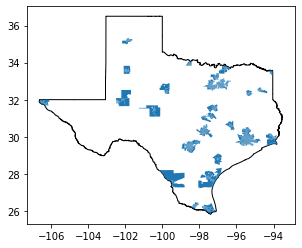

In [8]:
z = geopandas.read_file(outdir+'central_city_tracts_state_{0:02d}.shp'.format(state_numbers_list[sno]))
# #z.plot()

colnames_df = pandas.read_csv(outdir+'column_names.csv')
for i in range(0, len(z.columns.tolist())-1):
    z = z.rename(columns={z.columns.tolist()[i]: colnames_df.columns.tolist()[i]})
z = z.set_index('GEOID', drop=True)

fig, ax = plt.subplots(1,1)
state_shapefiles_gdf[state_shapefiles_gdf['STATEFP'] == state_numbers_list[sno]].plot(ax=ax, color='None', edgecolor='black')
z.plot(ax=ax)
print('Found {0:.0f} matching census tracts.'.format(len(z)))

# plt.xlim([-159,-156])
# plt.ylim([20.5,22])
plt.show() 


In [ ]:
# statey = 35
# fig, ax = plt.subplots(1,1,figsize=(6*scale,8*scale))


# print('Tracts that overlap multiple cities: {0:,.0f}'.format(len(tract_shapefiles_gdf[(tract_shapefiles_gdf['STATEFP'] == statey) & (tract_shapefiles_gdf['overlaps_multiple_places'] == True)])))

# state_shapefiles_gdf[state_shapefiles_gdf['STATEFP'] == statey].plot(ax=ax, color='none', edgecolor='blue')
# msa_central_cities_gdf[msa_central_cities_gdf['STATEFP'] == statey].plot(ax=ax, color='pink')
# tract_shapefiles_gdf[(tract_shapefiles_gdf['STATEFP'] == statey) & (tract_shapefiles_gdf['overlaps_multiple_places'] == True)].plot(ax=ax, color='none', edgecolor='black')

# # plt.xlim(-94.4,-93.6)
# # plt.ylim(36,36.5)
# #plt.show()
# if (len(tract_shapefiles_gdf[(tract_shapefiles_gdf['STATEFP'] == statey) & (tract_shapefiles_gdf['overlaps_multiple_places'] == True)]) > 0):
#     plt.savefig(thisdir+'overlap_multiple_cities/state{0:02d}'.format(statey))



In [ ]:
# unary_union(tract_shapefiles_gdf.geometry.tolist()).boundary

In [ ]:
# Multiple overlap tracts

# AL
#tract_shapefiles_gdf[tract_shapefiles_gdf.index == '01073012910']
#caution: tract 01073012910 matches 2 principal cities! (Jefferson County, Census Tract 129.10)
#.  Overlaps 0107000 (Birmingham) with an area of 1,558,867 sq m...
#.  Overlaps 0135896 (Hoover) with an area of 414,694 sq m...



In [ ]:
# tract_shapefiles_gdf.columns[tract_shapefiles_gdf['principal_city_geoid'].notnull()].sample(1).T


In [ ]:
# s = time.time()
# print('writing outfile...')
# tract_shapefiles_gdf.to_file(census_shapefile_tiger_basedir+'all_tracts_for_central_cities.shp')
# e = time.time()
# g = g + (e-s)
# print('Grand total time: {0:,.0f} seconds!'.format(g))


